<a href="https://colab.research.google.com/github/Isak-Petrin/distributional_RL_python/blob/main/Welcome_to_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gymnasium
!pip install pygame

In [42]:
from enum import Enum
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
from gymnasium.envs.registration import register
import math

class RandomWalk(gym.Env):
    def __init__(
        self,
        param: dict | None = None,
      ):
        self.l = 7
        self.start = self.l // 2
        self.observation_space = gym.spaces.Discrete(self.l)
        self.action_space = gym.spaces.Discrete(2)

    def _get_obs(self):
        return self.state
    def _get_info(self):
        return {'l': self.l}


    def reset(self,seed=None, options=None):
        self.state = self.start
        obs = self._get_obs()
        info = self._get_info()
        return obs,info

    def step(self, action: int):

      # store current observation as obs (pre-transition)
      obs = self._get_obs()

      # default settings
      self.done = False
      reward = 0

      # transition
      if action:
          self.state += 1
      else:
          self.state -= 1

      # clamp or check terminal
      if self.state == 0:
          self.done = True
          reward = np.random.normal(loc=2, scale = 0.5)
      elif self.state == self.l-1:
          self.done = True
          reward = np.random.normal(loc=4, scale = 0.5)
      next_obs = self._get_obs()
      info = self._get_info()

    # return obs and next_obs explicitly
      return obs, next_obs, reward, self.done, False, info




In [43]:
import gymnasium as gym
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

class O_CatTD:
    def __init__(
        self,
        env: gym.Env,
        alpha: float,
        theta_range: list[int,int],
        resolution: int,
        policy: int,
        gamma: float,
    ):
        self.alpha = alpha
        self.gamma = gamma
        self.env = env
        self.min_theta = theta_range[0]
        self.max_theta = theta_range[1]
        self.resolution = resolution
        self.theta_lst = np.linspace(self.min_theta, self.max_theta, resolution)
        self.m = len(self.theta_lst)
        self.p = [np.ones(self.m) * (1/self.m) for _ in range(self.env.observation_space.n)]
        self.policy = policy
        self.plot_lst = [np.array(copy.deepcopy(self.p))]
        self.t = 0
        self.k = 1e-6


    def find_i_star(self,g):
        bool_lst = self.theta_lst <= g
        i_star = np.where(bool_lst)[0].max()
        return i_star

    def get_alpha(self):
      return self.alpha / (1 + self.k * self.t)


    def learn_distribution(self, n_episodes: int):
        for episode in tqdm(range(n_episodes)):

            obs, info = self.env.reset()

            done = False

            t = 0
            while not done:
                a = np.random.randint(2)
                p_tilde = np.zeros(self.m, dtype=np.float64)
                s, sn, reward, done, _ , info, = self.env.step(a)
                for j in range(self.m):
                    if done:
                        g = reward
                    else:
                        g = reward + self.gamma * self.theta_lst[j]
                    if g <= self.min_theta:
                        p_tilde[0] += self.p[sn][j]
                    elif g >= self.max_theta:
                        p_tilde[self.m - 1] += self.p[sn][j]
                    else:
                        i_star = self.find_i_star(g)
                        zeta = (g - self.theta_lst[i_star]) / (self.theta_lst[i_star + 1] - self.theta_lst[i_star])
                        p_tilde[i_star] += (1-zeta) * self.p[sn][j]
                        p_tilde[i_star + 1] += zeta * self.p[sn][j]


                for i in range(self.m):
                    self.p[s][i] = (1 - self.alpha) * self.p[s][i] + self.alpha * p_tilde[i]

            self.plot_lst.append(np.array(copy.deepcopy(self.p)))
            self.t += 1






toy_env = RandomWalk()

catTD2 = O_CatTD(env = toy_env, alpha = 1e-3,theta_range=[-2,8],resolution = 50, policy = 1, gamma=1)
catTD2.learn_distribution(25000)



100%|██████████| 25000/25000 [01:40<00:00, 248.47it/s]


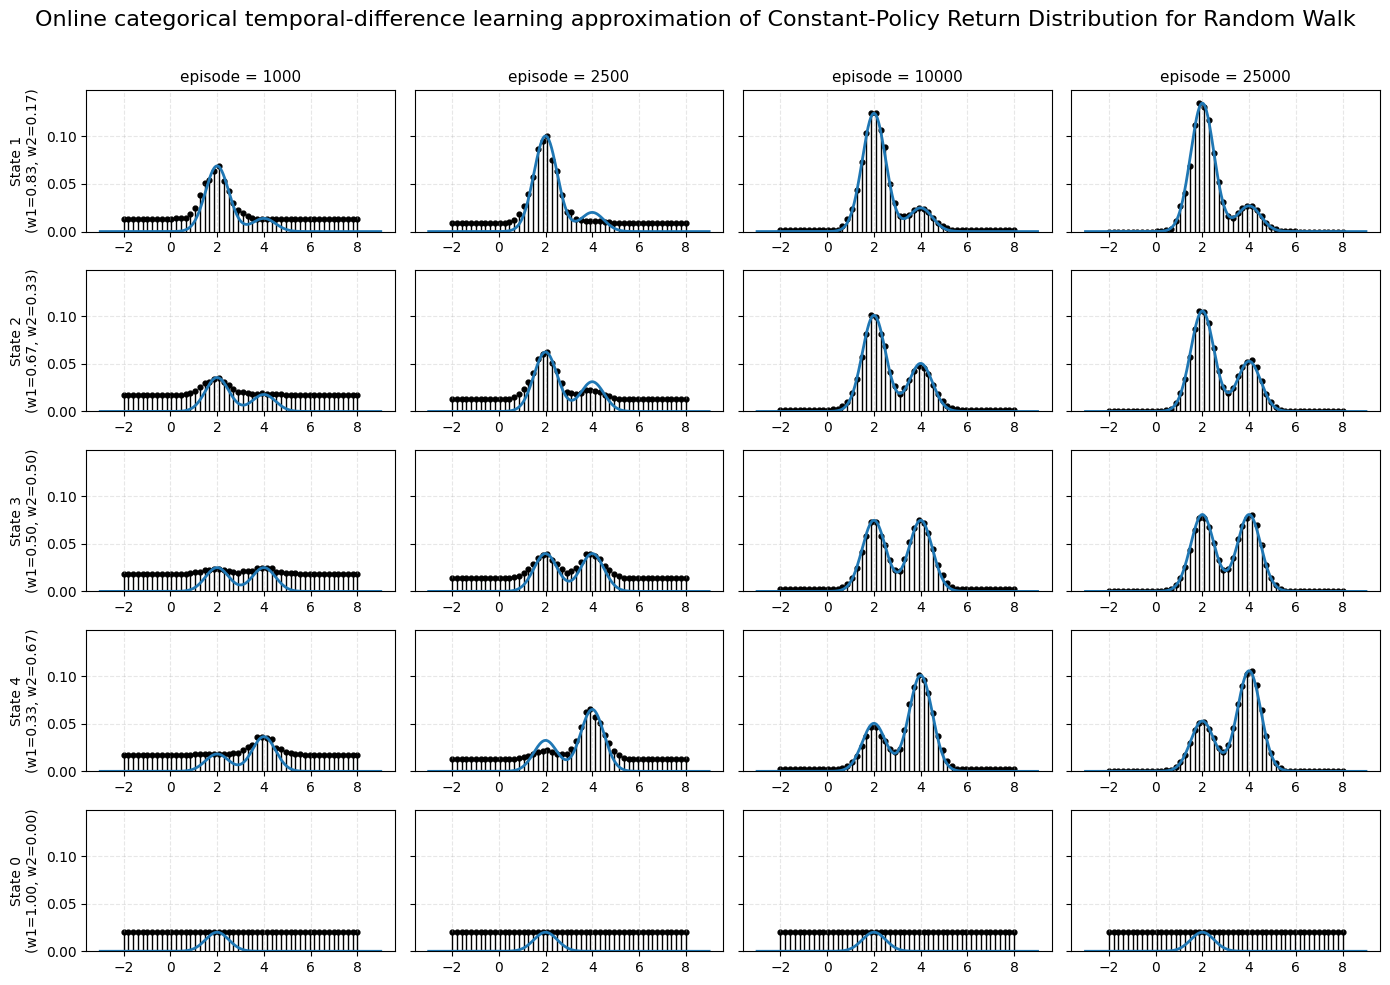

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_all_states_over_time(
    locations,
    plot_lst,
    states,             # e.g. [1,2,3,4,5]
    timesteps,          # e.g. [1000, 5000, 20000, 25000]
    mu_left, sigma_left,
    mu_right, sigma_right,
    n_points=400,
    figsize=(14, 10)
):

    locations = np.asarray(locations)

    # Precompute x-range
    xs = np.linspace(min(locations)-1, max(locations)+1, n_points)

    # Global y-scaling across all states & timesteps
    global_max = max(
        np.max(plot_lst[t][s])
        for s in states
        for t in timesteps
    )
    y_max = global_max * 1.1

    fig, axes = plt.subplots(
        len(states), len(timesteps),
        figsize=figsize,
        sharey=True
    )

    for row_idx, s in enumerate(states):

        # ---- Compute weights for this state ----
        # state 1 → w1=5/6
        # state 5 → w1=1/6
        w1 = (6 - s) / 6      # decreasing
        w2 = s / 6            # increasing

        # Precompute mixture for this state
        f1 = norm.pdf(xs, loc=mu_left,  scale=sigma_left)
        f2 = norm.pdf(xs, loc=mu_right, scale=sigma_right)
        mixture_raw = w1 * f1 + w2 * f2

        for col_idx, t in enumerate(timesteps):

            ax = axes[row_idx][col_idx]
            heights = np.asarray(plot_lst[t][s])

            # Scale mixture to spike amplitude
            mixture = mixture_raw * (max(heights) / max(mixture_raw))

            # Dirac spikes
            ax.vlines(locations, 0, heights, color='black', linewidth=1.0)
            ax.scatter(locations, heights, color='black', s=12)

            # Mixture curve
            ax.plot(xs, mixture, linewidth=2)

            # Labels
            if col_idx == 0:
                ax.set_ylabel(f"State {s}\n(w1={w1:.2f}, w2={w2:.2f})", fontsize=10)

            if row_idx == 0:
                ax.set_title(f"episode = {t}", fontsize=11)

            ax.grid(True, linestyle='--', alpha=0.3)
            ax.set_ylim(0, y_max)

    fig.suptitle("Online categorical temporal-diﬀerence learning approximation of Constant-Policy Return Distribution for Random Walk", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    fig = plt.gcf()  # get current figure
    fig.savefig("C51_constant_policy_grid.pdf", bbox_inches="tight")

    plt.show()



# ---- RUN IT ----

states = [1, 2, 3, 4, 0]
timesteps = [1000, 2500, 10000, 25000]

plot_all_states_over_time(
    locations=catTD2.theta_lst,
    plot_lst=catTD2.plot_lst,
    states=states,
    timesteps=timesteps,
    mu_left=2, sigma_left=1/2,
    mu_right=4, sigma_right=1/2
)


In [59]:
w = catTD2.theta_lst
mu_lst = []
for s in range(1,6):
  mu_lst.append(sum([a*b for a,b in zip(w,catTD2.p[s])]))
var_lst = []
for s in range(1,6):
  var_lst.append(sum([b*(a - mu_lst[s-1])**2 for a,b in zip(w,catTD2.p[s])]))

In [60]:
var_lst

[np.float64(0.8395503573843383),
 np.float64(1.1777693900516013),
 np.float64(1.2783654969753113),
 np.float64(1.1546136590646614),
 np.float64(0.8334508003809831)]

In [74]:
w = catTD.theta_lst
p = catTD.plot_lst[400]
mu_lst = []
for s in range(1,6):
  mu_lst.append(sum([a*b for a,b in zip(w,p[s])]))
var_lst = []
for s in range(1,6):
  var_lst.append(sum([b*(a - mu_lst[s-1])**2 for a,b in zip(w,p[s])]))

In [75]:
var_lst

[np.float64(0.4036641322940719),
 np.float64(0.26637683882263985),
 np.float64(0.2628776089744611),
 np.float64(0.26073979805171177),
 np.float64(0.2631929163772574)]

In [76]:
mu_lst

[np.float64(3.926256767909845),
 np.float64(4.001046963353583),
 np.float64(4.002983932280874),
 np.float64(4.003686543837082),
 np.float64(4.00646531115388)]

In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.signal import savgol_filter
class quantile:
    def __init__(self, m: int):
        self.m = m
        self.theta = np.linspace(-2,2,self.m)

    def get_theta(self):
        return self.theta
    def set_theta(self,theta):
        self.theta = theta
    def add_theta(self, diff):
        self.theta += diff
    def sample(self):
        return np.random.choice(self.theta)
    def mean(self):
        return np.mean(self.theta)

class container:
    def __init__(self, x0):
        self.hist = []
        self.xs = [x0]
        self.rs = []
        self.ds = []

    def add(self, obs: tuple):
        self.hist.append(obs)
        self.xs.append(obs[0])
        self.rs.append(obs[1])
        self.ds.append(obs[2])

    def get_xs(self):
        return self.xs
    def get_rs(self):
        return self.rs
    def get_x(self,t):
        return self.xs[t]
    def get_d(self,t):
        return self.ds[t]

    def reset(self, x0):
        self.hist = []
        self.xs = [x0]
        self.rs = []
        self.ds = []


class QRTDlAgent:
    def __init__(self, m: int, l: float ,obs_space: int, gamma: float, alpha: float, x0, bootstrap: bool, kappa: bool):
        self.m = m
        self.l = l
        self.bootstrap = bootstrap
        self.q = {x: quantile(m = self.m) for x in range(obs_space)}
        self.tau = np.asarray([(2*i - 1) / (2*self.m) for i in range(1,self.m+1)])
        self.gamma = gamma
        self.N = {x: 0 for x in range(obs_space)}
        self.container = container(x0=x0)
        self.trace = lambda s: (1 - self.l) * self.l**(s - 1)
        self.t = 0
        self.alpha0 = alpha
        self.episode = 0
        self.kappa = kappa

    def reset(self,x0):
        self.t = 0
        self.episode += 1
        self.container.reset(x0)
    def get_mean(self,x):
        return self.q[x].mean()
    def get_xs(self):
        return self.container.get_xs()

    def get_ds(self,t):
        return self.container.get_d(t)

    def get_q(self, x):
        return self.q[x]
    def get_xt(self,t):
        x = self.container.get_x(t = t)
        return x,self.q[x].get_theta()

    def _huber_grad(self, u):
        k = float(self.kappa)  # ensure numeric
        return np.where(np.abs(u) <= k, u / k, np.sign(u))


    def get_alpha(self, x, trc):
        # either do not mutate N here...
        eff_visits = self.N[x] + trc
        alpha_x = self.alpha0 / ((1.0 + eff_visits) ** 0.8)
        return max(alpha_x, 1e-4)


    def get_theta(self, x):
        return self.q[x].get_theta()

    def add_diff(self, x, diff):
        self.q[x].add_theta(diff)

    def get_tau(self):
        return self.tau

    def project_monotone(self, x):
        theta = self.q[x].get_theta()
        theta = np.maximum.accumulate(theta)
        self.q[x].set_theta(theta)

    def store(self,x,r, done):
        self.container.add((x,r,done))

    def update(self, x, x_n, r, done: bool):
        x = x_n
        self.t += 1

        self.store(x, r, done)

        for i in range(self.t):
            h = self.t - i
            target = self.get_target(t=i, h=h)          # scalar if bootstrap else vector (len m)
            x_i, theta = self.get_xt(t=i)               # theta shape: (m,)
            xs = self.get_xs()
            adj = 1

            if xs.count(x_i) >= 2:
                if i != (len(xs)-1 -xs[::-1].index(x_i)):
                    continue

            #if xs.count(x_i) >= 2:
            #    adj = xs.count(x_i)
            #if xs.count(x_i) >= 2:
            #    if i != (xs.index(x_i)):
            #        continue

            trc   = self.trace(s=h)
            alpha = self.get_alpha(x=x_i, trc=trc)

            if self.bootstrap:
                # target is scalar -> deltas per quantile
                delta = target - theta                  # shape: (m,)
                weight = np.abs(self.tau - (delta < 0).astype(float))  # |tau - 1{delta<0}|
                g = weight * self._huber_grad(delta)    # elementwise
                grad = alpha * trc * g                  # optional: / self.m for stability
            else:
                delta = target[None, :] - theta[:, None]                       # (m, m)
                weight = np.abs(self.tau[:, None] - (delta < 0).astype(float)) # (m, m)
                g = weight * self._huber_grad(delta)                           # (m, m)
                grad = self.alpha0 * trc * g.mean(axis=1)                          # average over j -> (m,)

            self.add_diff(x=x_i, diff= grad)


    def get_target(self, t,h):
        rs = self.container.get_rs()
        xb = self.container.get_x(t = t+h)
        if self.bootstrap:
            target = 0
            for i,k in enumerate(range(t,t+h)):
                target += self.gamma**i * rs[k]
                if self.get_ds(t = k) == True:
                    return target
            return target + self.q[xb].sample() * self.gamma**h
        else:
            target = np.zeros(self.m)
            for i,k in enumerate(range(t,t+h)):
                target += self.gamma**i * np.ones(self.m) * rs[k]
                if self.get_ds(t = k) == True:
                    return target
            return target + self.get_theta(xb) * self.gamma**h


In [ ]:
G = 0
for i in range(7):
  G += -0.1 * 0.95**i

G + 20 * 0.95**7

13.363420514062495

<>:52: SyntaxWarning: invalid escape sequence '\l'
<>:52: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1337022246.py:52: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(range(episodes), vs[agent], label=f'$\lambda$ = {agent.l}')
100%|██████████| 25000/25000 [09:06<00:00, 45.76it/s]


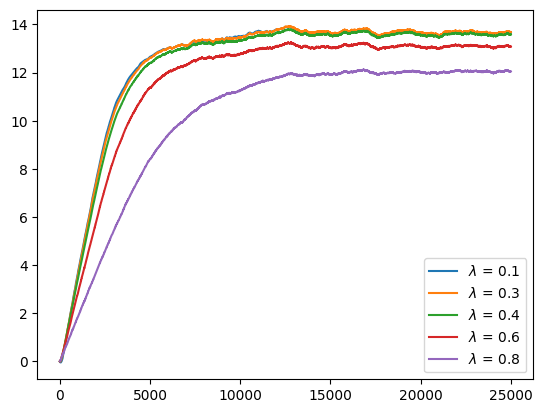

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import sys


episodes = 25000
gamma = 0.95
alpha = 0.05
length = 7
bootstrap = False
x0 = 2
m = 15
kappa = 2

agent1 = QRTDlAgent(m = m,obs_space=length,l = .1 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent2 = QRTDlAgent(m = m,obs_space=length,l = .3 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent3 = QRTDlAgent(m = m,obs_space=length,l = .4 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent4 = QRTDlAgent(m = m,obs_space=length,l = .6 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent5 = QRTDlAgent(m = m,obs_space=length,l = .8 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)


agents = [agent1,agent2,agent3, agent4, agent5]

env = RandomWalk()
vs = {agent: [] for agent in agents}

for episode in tqdm(range(episodes)):
    obs, _ = env.reset()
    for agent in agents:
        vs[agent].append(agent.q[3].theta.mean())
        agent.reset(x0 = obs)

    done = False
    prev = length // 2
    while not done:
        action = np.random.randint(2)
        info = env.step(action)

        obs = info[0]
        reward = info[1]
        done = info[2]

        for agent in agents:
            agent.update(x_n=obs,x=prev, r = reward, done = done)
        prev = obs



for agent in agents:
    plt.plot(range(episodes), vs[agent], label=f'$\lambda$ = {agent.l}')
plt.legend()
plt.show()


In [ ]:
agent1.q[3].theta

array([10.55531054, 11.06590604, 11.40123588, 11.68302715, 11.94329689,
       12.22345887, 12.51105126, 12.83119462, 13.21180896, 13.65739179,
       14.1989751 , 14.81411197, 15.4317169 , 16.0655693 , 16.92494612])

<>:52: SyntaxWarning: invalid escape sequence '\l'
<>:52: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-295618120.py:52: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(range(episodes), vs[agent], label=f'$\lambda$ = {agent.l}')
100%|██████████| 10000/10000 [05:46<00:00, 28.88it/s]


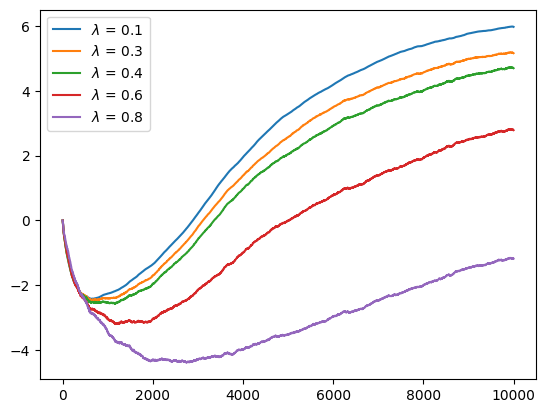

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import sys


episodes = 10000
gamma = 0.95
alpha = 0.05
length = 7
bootstrap = False
x0 = 2
m = 10
kappa = 1

agent1 = QRTDlAgent(m = m,obs_space=length,l = .1 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent2 = QRTDlAgent(m = m,obs_space=length,l = .3 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent3 = QRTDlAgent(m = m,obs_space=length,l = .4 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent4 = QRTDlAgent(m = m,obs_space=length,l = .6 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent5 = QRTDlAgent(m = m,obs_space=length,l = .8 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)


agents = [agent1,agent2,agent3, agent4, agent5]

env = RandomWalk()
vs = {agent: [] for agent in agents}

for episode in tqdm(range(episodes)):
    obs, _ = env.reset()
    for agent in agents:
        vs[agent].append(agent.q[3].mean())
        agent.reset(x0 = obs)

    done = False
    prev = length // 2
    while not done:
        action = np.random.randint(2)
        info = env.step(action)

        obs = info[0]
        reward = info[1]
        done = info[2]

        for agent in agents:
            agent.update(x_n=obs,x=prev, r = reward, done = done)
        prev = obs



for agent in agents:
    plt.plot(range(episodes), vs[agent], label=f'$\lambda$ = {agent.l}')
plt.legend()
plt.show()


In [70]:
import gymnasium as gym
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

class O_CatTD:
    def __init__(
        self,
        env: gym.Env,
        alpha: float,
        theta_range: list[int,int],
        resolution: int,
        policy: int,
        gamma: float,
    ):
        self.alpha = alpha
        self.gamma = gamma
        self.env = env
        self.min_theta = theta_range[0]
        self.max_theta = theta_range[1]
        self.resolution = resolution
        self.theta_lst = np.linspace(self.min_theta, self.max_theta, resolution)
        self.m = len(self.theta_lst)
        self.p = [np.ones(self.m) * (1/self.m) for _ in range(self.env.observation_space.n)]
        self.policy = policy
        self.plot_lst = [np.array(copy.deepcopy(self.p))]
        self.t = 0
        self.k = 1e-6

    def mu(self,s):
        return sum([a*b for a,b in zip(self.theta_lst,self.p[s])])

    def find_i_star(self,g):
        bool_lst = self.theta_lst <= g
        i_star = np.where(bool_lst)[0].max()
        return i_star

    def get_alpha(self):
      return self.alpha / (1 + self.k * self.t)


    def learn_distribution(self, n_episodes: int):
        for episode in tqdm(range(n_episodes)):

            s, info = self.env.reset()
            done = False
            t = 0
            alpha = self.get_alpha()
            while not done:
                eps = np.random.random()
                if eps < 0.05:
                    a = np.random.randint(2)
                else:
                  if self.mu(s+1) > self.mu(s-1):
                      a = 1
                  else:
                      a = 0
                t += 1
                p_tilde = np.zeros(self.m, dtype=np.float64)
                s, sn, reward, done, _ , info, = self.env.step(a)
                for j in range(self.m):
                    if done:
                        g = reward
                    else:
                        g = reward + self.gamma * self.theta_lst[j]
                    if g <= self.min_theta:
                        p_tilde[0] += self.p[sn][j]
                    elif g >= self.max_theta:
                        p_tilde[self.m - 1] += self.p[sn][j]
                    else:
                        i_star = self.find_i_star(g)
                        zeta = (g - self.theta_lst[i_star]) / (self.theta_lst[i_star + 1] - self.theta_lst[i_star])
                        p_tilde[i_star] += (1-zeta) * self.p[sn][j]
                        p_tilde[i_star + 1] += zeta * self.p[sn][j]


                for i in range(self.m):
                    self.p[s][i] = (1 - alpha) * self.p[s][i] + alpha * p_tilde[i]


            if episode % 1000 == 0:
              self.plot_lst.append(np.array(self.p))  # no deepcopy; see next point
            self.t += 1






toy_env = RandomWalk()

catTD = O_CatTD(env = toy_env, alpha = 1e-3,theta_range=[-2,8],resolution = 50, policy = 1, gamma=1)
catTD.learn_distribution(500000)



 80%|████████  | 401975/500000 [33:14<08:06, 201.56it/s] 


KeyboardInterrupt: 

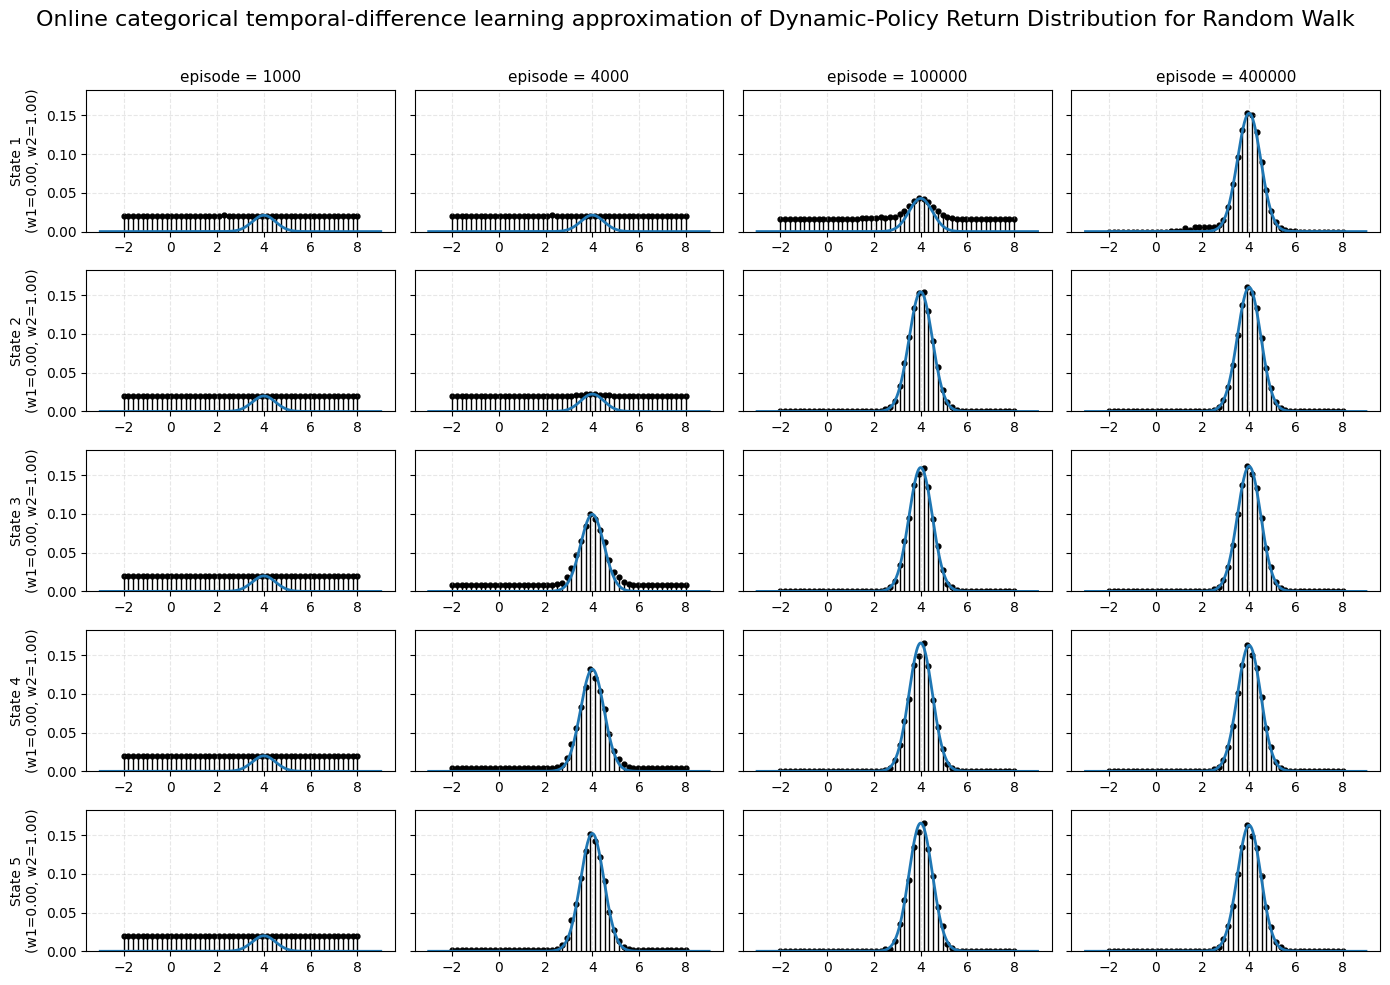

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_all_states_over_time(
    locations,
    plot_lst,
    states,             # e.g. [1,2,3,4,5]
    timesteps,          # e.g. [1000, 5000, 20000, 25000]
    mu_left, sigma_left,
    mu_right, sigma_right,
    n_points=400,
    figsize=(14, 10)
):

    locations = np.asarray(locations)

    # Precompute x-range
    xs = np.linspace(min(locations)-1, max(locations)+1, n_points)

    # Global y-scaling across all states & timesteps
    global_max = max(
        np.max(plot_lst[t][s])
        for s in states
        for t in timesteps
    )
    y_max = global_max * 1.1

    fig, axes = plt.subplots(
        len(states), len(timesteps),
        figsize=figsize,
        sharey=True
    )

    for row_idx, s in enumerate(states):

        # ---- Compute weights for this state ----
        # state 1 → w1=5/6
        # state 5 → w1=1/6
        w1 = 0      # decreasing
        w2 = 1            # increasing

        # Precompute mixture for this state
        f1 = norm.pdf(xs, loc=mu_left,  scale=sigma_left)
        f2 = norm.pdf(xs, loc=mu_right, scale=sigma_right)
        mixture_raw = w1 * f1 + w2 * f2

        for col_idx, t in enumerate(timesteps):

            ax = axes[row_idx][col_idx]
            heights = np.asarray(plot_lst[t][s])

            # Scale mixture to spike amplitude
            mixture = mixture_raw * (max(heights) / max(mixture_raw))

            # Dirac spikes
            ax.vlines(locations, 0, heights, color='black', linewidth=1.0)
            ax.scatter(locations, heights, color='black', s=12)

            # Mixture curve
            ax.plot(xs, mixture, linewidth=2)

            # Labels
            if col_idx == 0:
                ax.set_ylabel(f"State {s}\n(w1={w1:.2f}, w2={w2:.2f})", fontsize=10)

            if row_idx == 0:
                ax.set_title(f"episode = {t*1000}", fontsize=11)

            ax.grid(True, linestyle='--', alpha=0.3)
            ax.set_ylim(0, y_max)

    fig.suptitle("Online categorical temporal-diﬀerence learning approximation of Dynamic-Policy Return Distribution for Random Walk", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    fig = plt.gcf()  # get current figure
    fig.savefig("C51_dynamical_policy_grid.pdf", bbox_inches="tight")

    plt.show()



# ---- RUN IT ----

states = [1, 2, 3, 4, 5]
timesteps = [1, 4, 100, 400]

plot_all_states_over_time(
    locations=catTD.theta_lst,
    plot_lst=catTD.plot_lst,
    states=states,
    timesteps=timesteps,
    mu_left=2, sigma_left=1/2,
    mu_right=4, sigma_right=1/2
)


In [52]:
[5,3,2,1]

TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [447]:
class quantile:
    def __init__(self, m: int):
        self.m = m
        self.theta = np.linspace(-2,2,self.m)

    def get_theta(self):
        return self.theta
    def set_theta(self,theta):
        self.theta = theta
    def add_theta(self, diff):
        self.theta += diff
    def sample(self):
        return np.random.choice(self.theta)
    def mean(self):
        return np.mean(self.theta)


class env_qs:
    def __init__(self, m: int, obs_space: int, gamma: float, alpha: float):
        self.m = m
        self.obs_space = obs_space                    # <--- store this
        self.q = {x: quantile(m=self.m) for x in range(obs_space)}
        self.tau = np.asarray([(2*i - 1) / (2*self.m) for i in range(1, self.m+1)])
        self.gamma = gamma
        self.alpha0 = alpha       # base step-size
        self.l = "qrtd"
        self.t = 0                # global update counter
        self.episode = 0
        self.k = 1e-5             # decay factor
        self.plt_lst = []         # will hold snapshots: (obs_space, m)

    def reset(self, x0):
        return

    def get_q(self, x):
        return self.q[x]

    def get_alpha(self):
        return self.alpha0 / (1 + self.k * self.episode)

    def get_theta(self, x):
        return self.q[x].get_theta()

    def add_diff(self, x, diff):
        self.q[x].add_theta(diff)

    def get_tau(self):
        return self.tau

    def project_monotone(self, x):
        theta = self.q[x].get_theta()
        theta = np.maximum.accumulate(theta)
        self.q[x].set_theta(theta)

    def _snapshot_thetas(self):
        """
        Take a snapshot of all θ(s, :) for plotting.
        Result: array shape (obs_space, m)
        """
        thetas = np.vstack(
            [self.q[s].get_theta() for s in range(self.obs_space)]
        )
        self.plt_lst.append(thetas.copy())

    def update(self, x, x_n, r, done):
        theta_x  = self.get_theta(x)
        theta_xn = self.get_theta(x_n)
        alpha    = self.get_alpha()

        # ---- target atoms g_j ----
        if done:
            g = np.full(self.m, r)              # shape (m,)
        else:
            g = r + self.gamma * theta_xn       # shape (m,)

        # ---- indicator matrix I[i, j] = 1[g_j < theta_x[i]] ----
        indicator = (g[None, :] < theta_x[:, None])  # shape (m, m)

        # mean over j
        indicator_mean = indicator.mean(axis=1)       # shape (m,)

        # grad[i] = alpha * (tau[i] - mean_j I[i,j])
        grad = alpha * (self.tau - indicator_mean)    # shape (m,)

        self.add_diff(x, grad)
        self.project_monotone(x)

        if done == True:
            self._snapshot_thetas()
            self.episode += 1






<>:54: SyntaxWarning: invalid escape sequence '\l'
<>:54: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-198306015.py:54: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(range(episodes), vs[agent], label=f'$\lambda$ = {agent.l}')
100%|██████████| 500000/500000 [22:14<00:00, 374.72it/s]


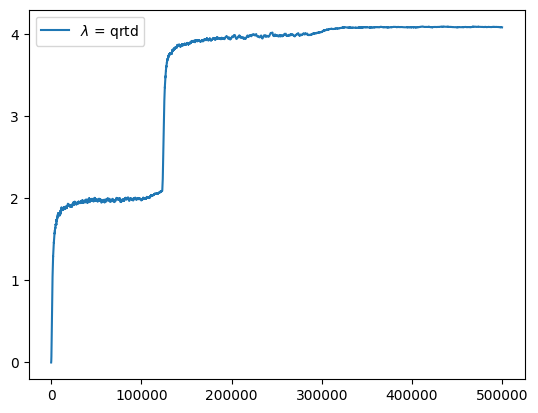

In [451]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import sys


episodes = 500000
gamma = 1
alpha = 1e-2
length = 7
bootstrap = False
x0 = 3
m = 50
kappa = 1


agent1 = env_qs(m = m,obs_space=length, gamma = gamma, alpha=alpha)
agents = [agent1]

env = RandomWalk()
vs = {agent: [] for agent in agents}

for episode in tqdm(range(episodes)):
    obs, _ = env.reset()
    for agent in agents:
        vs[agent].append(agent.q[3].mean())
        agent.reset(x0 = obs)


    done = False
    prev = length // 2
    while not done:
        for agent in agents:
          if np.random.random() < 0.05:
            action = np.random.randint(2)
          else:
            if agent1.get_q(prev + 1).mean() > agent1.get_q(prev - 1).mean():
                action = 1
            else:
                action = 0
            info = env.step(action)

            prev = info[0]
            obs = info[1]
            reward = info[2]
            done = info[3]
            agent.update(prev,obs, reward, done)



for agent in agents:
    plt.plot(range(episodes), vs[agent], label=f'$\lambda$ = {agent.l}')
plt.legend()
plt.show()


In [449]:
len(agent1.plt_lst)

500000

In [429]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq


def mixture_cdf(x, mu1, var1, mu2, var2, w1=0.5):
    """
    CDF of a mixture of two normal distributions:
        X ~ w1 * N(mu1, var1) + (1 - w1) * N(mu2, var2)

    Parameters
    ----------
    x : float or array
        Evaluation point(s).
    mu1, var1 : float
        Mean and variance of the first normal.
    mu2, var2 : float
        Mean and variance of the second normal.
    w1 : float in [0, 1]
        Mixture weight for the first normal. Second has weight (1 - w1).

    Returns
    -------
    float or array
        Value(s) of the mixture CDF at x.
    """
    sigma1 = np.sqrt(var1)
    sigma2 = np.sqrt(var2)

    # mixture CDF
    return w1 * norm.cdf(x, loc=mu1, scale=sigma1) + (1.0 - w1) * norm.cdf(x, loc=mu2, scale=sigma2)


def mixture_quantile(q, mu1, var1, mu2, var2, w1=0.5, bracket_factor=10.0):
    """
    Numerical quantile (inverse CDF) of the two-normal mixture.

    Solves F(x) = q using brentq.

    Parameters
    ----------
    q : float in (0, 1)
        Desired quantile level.
    mu1, var1, mu2, var2 : float
        Means and variances of the two normals.
    w1 : float
        Mixture weight for the first normal.
    bracket_factor : float
        Multiplier for standard deviations to set a root-finding bracket.

    Returns
    -------
    float
        x such that F(x) = q.
    """
    if not (0.0 < q < 1.0):
        raise ValueError("q must be strictly between 0 and 1.")

    sigma1 = np.sqrt(var1)
    sigma2 = np.sqrt(var2)
    sigma_max = max(sigma1, sigma2)

    # Center bracket around the means; make it wide enough to cover tails
    lower = min(mu1, mu2) - bracket_factor * sigma_max
    upper = max(mu1, mu2) + bracket_factor * sigma_max

    def f(x):
        return mixture_cdf(x, mu1, var1, mu2, var2, w1) - q

    # If for some reason the bracket is not sufficient, expand until it is
    max_expansions = 5
    expansions = 0
    while f(lower) > 0 or f(upper) < 0:
        lower -= bracket_factor * sigma_max
        upper += bracket_factor * sigma_max
        expansions += 1
        if expansions > max_expansions:
            raise RuntimeError("Failed to bracket the quantile root.")

    return brentq(f, lower, upper)


def mixture_quantiles(q_list, mu1, var1, mu2, var2, w1=0.5):
    """
    Compute several quantiles of the two-normal mixture.

    Parameters
    ----------
    q_list : list or array of floats in (0, 1)
        Quantile levels.
    mu1, var1, mu2, var2 : float
        Parameters of the two normals.
    w1 : float
        Mixture weight for the first normal.

    Returns
    -------
    np.ndarray
        Array of quantiles corresponding to q_list.
    """
    q_list = np.asarray(q_list, dtype=float)
    return np.array([
        mixture_quantile(q, mu1, var1, mu2, var2, w1=w1)
        for q in q_list
    ])


if __name__ == "__main__":
    # Example usage:
    mu1, var1 = 2, 1/4      # N(0, 1)
    mu2, var2 = 4, 1/4      # N(3, 2^2)
    w1 = 0                # equal mixture weights

    taus = (agent1.tau).tolist()

    qs = mixture_quantiles(taus, mu1, var1, mu2, var2, w1=w1)

    print("Quantile levels:", taus)
    print("Mixture quantiles:", qs)


Quantile levels: [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21, 0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65, 0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87, 0.89, 0.91, 0.93, 0.95, 0.97, 0.99]
Mixture quantiles: [2.83682606 3.0596032  3.17757319 3.26210449 3.32962248 3.38673594
 3.43680444 3.48178331 3.52291737 3.56105185 3.59678938 3.63057658
 3.66275512 3.6935935  3.72330764 3.75207483 3.78004342 3.80733977
 3.83407333 3.86034048 3.88622751 3.91181292 3.93716933 3.96236507
 3.98746555 4.01253445 4.03763493 4.06283067 4.08818708 4.11377249
 4.13965952 4.16592667 4.19266023 4.21995658 4.24792517 4.27669236
 4.3064065  4.33724488 4.36942342 4.40321062 4.43894815 4.47708263
 4.51821669 4.56319556 4.61326406 4.67037752 4.73789551 4.82242681
 4.9403968  5.16317394]


In [239]:
agent1.q[3].theta

array([-1.32559999, -0.61963739, -0.10711656,  1.06612171,  1.35876179,
        1.54741893,  1.58934616,  1.71088031,  1.74633215,  1.82446234,
        1.87893562,  1.91055977,  2.00467415,  2.03403366,  2.063354  ,
        2.16005307,  2.19054357,  2.21949509,  2.32787322,  2.36561158,
        2.40706812,  2.54148266,  2.59669224,  2.64923793,  2.88758439,
        3.07790584,  3.23193125,  3.3146181 ,  3.3839664 ,  3.55405   ,
        3.59615531,  3.63913074,  3.74749887,  3.78334514,  3.81313461,
        3.90601622,  3.94092579,  3.96902896,  4.05496309,  4.09245272,
        4.12417576,  4.21225229,  4.24906885,  4.28884241,  4.39356515,
        4.43389272,  4.47690085,  4.642572  ,  4.71196204,  4.78751218])

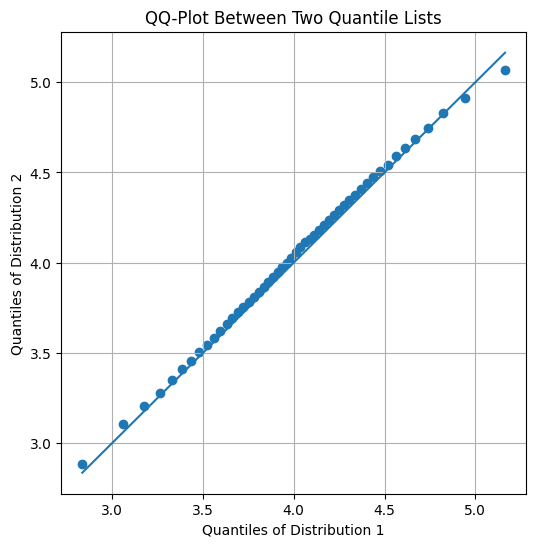

In [504]:
import numpy as np
import matplotlib.pyplot as plt

# Generate two example quantile lists
np.random.seed(42)

# Quantiles from two distributions
quantiles = np.linspace(0, 1, 50)

q1 = qs
q2 = agent1.plt_lst[300000][3]

# Create QQ-plot comparing the two quantile lists
plt.figure(figsize=(6, 6))
plt.scatter(q1, q2)

# Reference 45-degree line
min_val = min(q1.min(), q2.min())
max_val = max(q1.max(), q2.max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.xlabel("Quantiles of Distribution 1")
plt.ylabel("Quantiles of Distribution 2")
plt.title("QQ-Plot Between Two Quantile Lists")
plt.grid(True)

plt.show()


In [501]:
def build_true_quantiles_for_states(agent, mu1, var1, mu2, var2, N=6):
    """
    Compute the true quantiles for each state s using a two-normal mixture
    with weight w1(s) = s / N.

    Returns
    -------
    true_q : np.ndarray, shape (obs_space, m)
        Row s holds the true quantiles for state s at levels agent.tau.
    """
    m = agent.m
    obs_space = agent.obs_space
    taus = agent.tau

    true_q = np.zeros((obs_space, m))

    for s in range(obs_space):
        w1_s = 1-(s / N)  # mixture weight for the left normal in state s
        true_q[s, :] = mixture_quantiles(
            taus, mu1, var1, mu2, var2, w1=w1_s
        )

    return true_q

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_qq_over_time(agent,
                      true_quantiles,
                      states,
                      episodes_to_plot,
                      taus=None,
                      figsize=(14, 8)):
    """
    QQ-plot of model vs true quantiles over time + Wasserstein distances.

    Grid layout:
      - rows   = states
      - columns = episodes_to_plot (interpreted directly as indices into agent.plt_lst)

    Parameters
    ----------
    agent : env_qs instance
        Needs:
        - m
        - obs_space
        - plt_lst[k] : array of shape (obs_space, m)
    true_quantiles : np.ndarray
        Shape (obs_space, m). Row s: true quantiles in state s at levels agent.tau.
    states : list[int]
        States to put on the y-axis (rows), e.g. [1, 2, 3, 4, 5].
    episodes_to_plot : list[int]
        Indices into agent.plt_lst, e.g. [25000, 70000, 350000, 1500000].
        These should correspond to the episode counters you used when snapshotting.
    taus : array-like, optional
        Quantile levels (same length as m). If None, uses agent.tau.
    """

    m = agent.m
    if taus is None:
        taus = agent.tau
    taus = np.asarray(taus)

    # Grab snapshot arrays
    snapshots = []
    for ep in episodes_to_plot:
        if ep < 0 or ep >= len(agent.plt_lst):
            raise ValueError(
                f"Episode index {ep} out of range; "
                f"len(agent.plt_lst) = {len(agent.plt_lst)}"
            )
        snapshots.append(agent.plt_lst[ep])

    # ---- Global limits across all chosen states & times ----
    all_vals = []
    for s in states:
        q_true_s = true_quantiles[s]          # shape (m,)
        for snap in snapshots:
            q_model_s = snap[s, :]           # shape (m,)
            all_vals.append(q_true_s)
            all_vals.append(q_model_s)

    all_vals = np.concatenate(all_vals)
    vmin, vmax = all_vals.min(), all_vals.max()
    pad = 0.05 * (vmax - vmin if vmax > vmin else 1.0)
    vmin -= pad
    vmax += pad

    n_rows = len(states)
    n_cols = len(episodes_to_plot)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=figsize,
                             sharex=True,
                             sharey=True)

    if n_rows == 1:
        axes = np.array([axes])
    if n_cols == 1:
        axes = axes[:, None]

    for row, s in enumerate(states):
        q_true_s = true_quantiles[s]
        for col, (ep, snap) in enumerate(zip(episodes_to_plot, snapshots)):
            ax = axes[row, col]
            q_model_s = snap[s, :]  # model quantiles

            # QQ-scatter
            ax.scatter(q_true_s, q_model_s, s=8)

            # 45-degree reference line
            ax.plot([vmin, vmax], [vmin, vmax], linestyle='--', linewidth=1)

            # Wasserstein distance W1 from quantiles
            diffs = np.abs(q_true_s - q_model_s)
            W1 = np.trapz(diffs, x=taus)

            # Axis labels
            if row == n_rows - 1:
                ax.set_xlabel("True quantiles")
            if col == 0:
                ax.set_ylabel(f"State {s}\nModel quantiles")

            ax.set_title(f"episode = {ep+1}")

            # Put W1 just under the plot (centered)

            ax.text(
                0.03, 0.97,
                rf"$W_1 \approx {W1:.3f}$",
                transform=ax.transAxes,
                ha="left", va="top",
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.2",
                          fc="white", ec="none", alpha=0.8)
                )


            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)

    plt.tight_layout()
    # Add suptitle *before* tight_layout, then reserve space for it
    fig.suptitle(
        "QRTD approximation of quantiles of Dynamic-Policy Return Distribution for Random Walk",
        fontsize=16,
        y=0.98
    )

    # Reserve space at top so title doesn't overlap
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    fig.savefig("QRTD_dynamic_policy_grid.pdf", bbox_inches="tight")
    plt.show()




In [456]:
agent1.tau

array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
       0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43,
       0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65,
       0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87,
       0.89, 0.91, 0.93, 0.95, 0.97, 0.99])

/tmp/ipython-input-2962556136.py:122: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  W1 = np.trapz(diffs, x=taus)


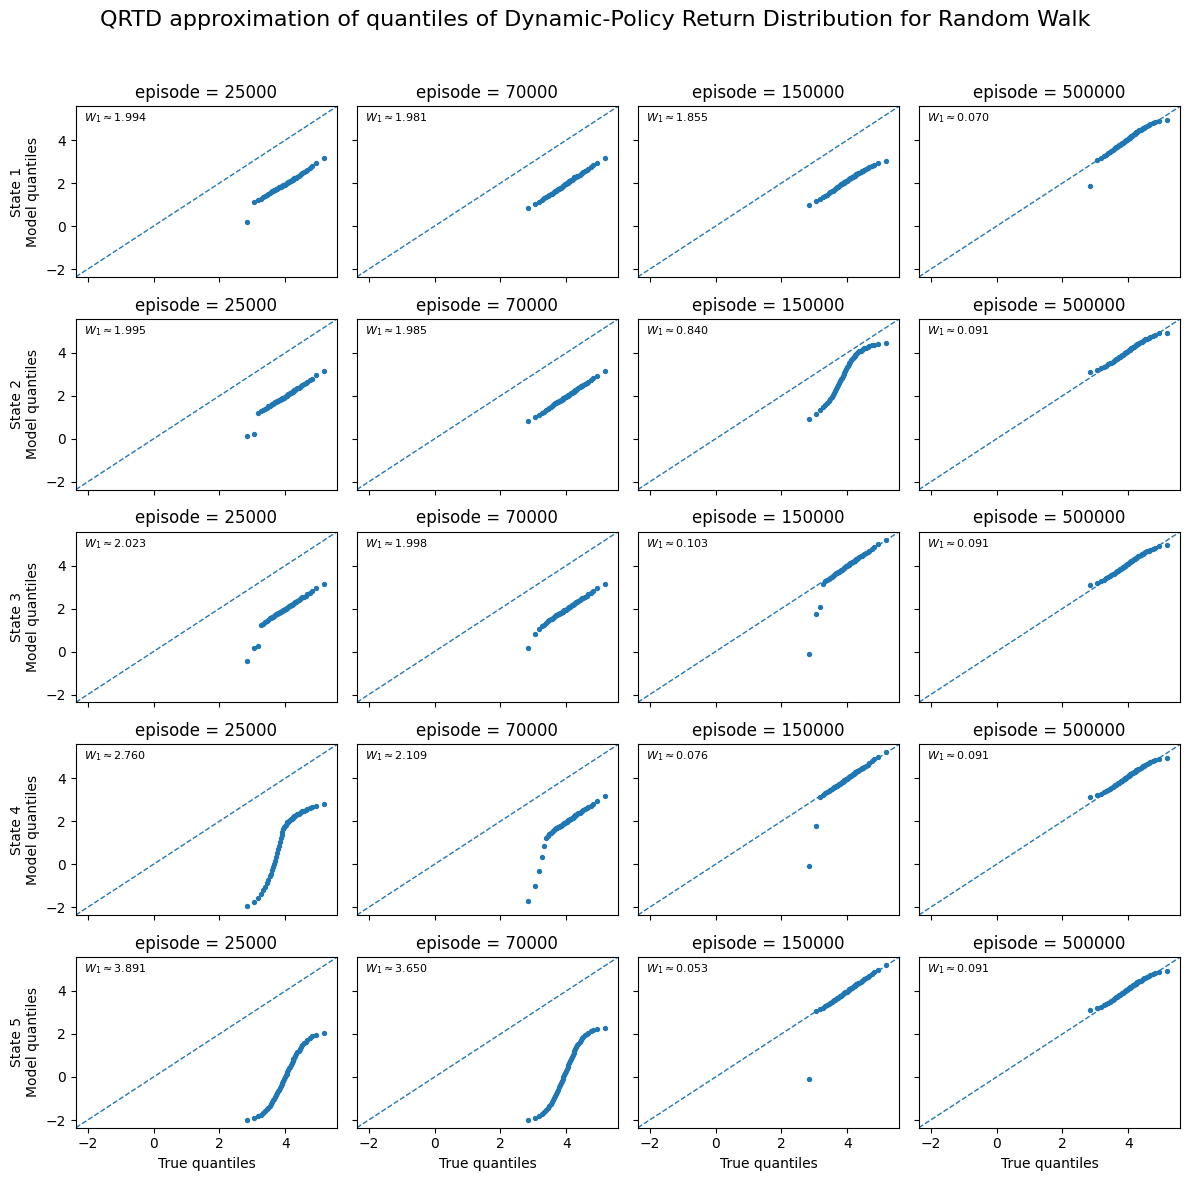

In [502]:
# Mixture parameters (same as in your example)
mu1, var1 = 2, 1/4
mu2, var2 = 4, 1/4
N = 6                           # fixed denominator in w1(s) = s/N

# Build true quantiles for all states using w1(s) = s/6
true_q_all_states = build_true_quantiles_for_states(
    agent1, mu1, var1, mu2, var2, N=N
)


states = [1, 2, 3, 4, 5]
snapshot_indices = [25000-1, 70000-1, 150000-1, 500000-1]  # the ones in your screenshot

plot_qq_over_time(
    agent=agent1,
    true_quantiles=q_true,  # built with your mixture and w1 = s/6
    states=states,
    episodes_to_plot=snapshot_indices,
    taus=agent1.tau,
    figsize=(12, 12)
)



In [464]:
import numpy as np
from scipy.stats import norm

# Quantile levels
taus = np.array([
    0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19,
    0.21, 0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39,
    0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59,
    0.61, 0.63, 0.65, 0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79,
    0.81, 0.83, 0.85, 0.87, 0.89, 0.91, 0.93, 0.95, 0.97, 0.99
])

# Normal distribution parameters
mu = 4
sigma = 1/2

# Compute quantiles
quantiles = norm.ppf(taus, loc=mu, scale=sigma)

print("Quantiles for N(mu, sigma^2):")
print(quantiles)


Quantiles for N(mu, sigma^2):
[2.83682606 3.0596032  3.17757319 3.26210449 3.32962248 3.38673594
 3.43680444 3.48178331 3.52291737 3.56105185 3.59678938 3.63057658
 3.66275512 3.6935935  3.72330764 3.75207483 3.78004342 3.80733977
 3.83407333 3.86034048 3.88622751 3.91181292 3.93716933 3.96236507
 3.98746555 4.01253445 4.03763493 4.06283067 4.08818708 4.11377249
 4.13965952 4.16592667 4.19266023 4.21995658 4.24792517 4.27669236
 4.3064065  4.33724488 4.36942342 4.40321062 4.43894815 4.47708263
 4.51821669 4.56319556 4.61326406 4.67037752 4.73789551 4.82242681
 4.9403968  5.16317394]


In [484]:
q_true = np.array([quantiles for i in range(0,6)])

In [489]:
len(agent1.tau)

50

In [487]:
len(q_true[0])

50